In [29]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [134]:
raw_data_path = constants.PATH_TO_CORTEX_all_params_z_score
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS

In [135]:
subjects_raw_data = DataProcessor(raw_data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
analyzed_data = StatisticsWrapper.calc_mean_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

In [136]:
def extract_outliers(data, param):
     outliers = {}
     threshold = 3

     for roi_value, roi_name in chosen_rois_dict.items():
          roi_to_check_data = data[data.ROI == roi_value]
          Q1 = roi_to_check_data[param].quantile(0.25)
          Q3 = roi_to_check_data[param].quantile(0.75)
          IQR = Q3 - Q1


          outliers_df = roi_to_check_data[(roi_to_check_data[param] < Q1 - threshold * IQR) | (roi_to_check_data[param] > Q3 + threshold * IQR)]

          if outliers_df.subjects.values.size > 0:
               outliers[roi_value] = outliers_df.subjects.tolist()

     return outliers

In [137]:
# outliers_counter = {}

# for param in params_to_work_with:
#     subjects_outliers_counter = {}
#     outliers = extract_outliers(chosen_data, param)

#     for roi, roi_outliers in outliers.items():
#             for outlier in roi_outliers:
#                 if outlier in subjects_outliers_counter:
#                     subjects_outliers_counter[outlier] += 1
#                     outliers_counter[outlier] += 1
#                 else:
#                     subjects_outliers_counter[outlier]  = 1
#                     if outlier not in outliers_counter:
#                         outliers_counter[outlier] = 1

#     subjects_outliers_counter = dict(sorted(subjects_outliers_counter.items(), key=lambda item: item[1], reverse=True))
#     # print(f'{param} outliers: {outliers}')
#     # print(f'{param} outliers counter: {subjects_outliers_counter}')
#     # print(f'{param} outliers counter: {outliers_counter}')
#     # print('----------------------------------------------------------')

# outliers_counter = dict(sorted(outliers_counter.items(), key=lambda item: item[1], reverse=True))
# print(f'outliers counter: {outliers_counter}')

# chosen_data = chosen_data[~chosen_data.subjects.isin(['H047_DC', 'H054_AE', 'H037_YB', 'H036_EV'])]
# chosen_data.subjects.nunique()

In [138]:
# data_path = os.path.join(constants.ANALYSIS_DIR, 'H054_AE')
# seg_path = os.path.join(data_path, os.listdir(data_path)[0], constants.BASIC_SEG)
# brain_path = os.path.join(data_path, os.listdir(data_path)[0], constants.MAP_R1)
# os.system(f'freeview -v {brain_path} {seg_path}:colormap=lut &')

In [139]:
group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

young_subjects.subjects.nunique(), old_subjects.subjects.nunique()

(19, 17)

In [109]:
def calculate_cv_for_subjects(data_groups, group_by_param, params, x_axis, use_reg=False, fig_size=(20, 8), connect_scatter=False):
    for param in params:
        # if 'Slope' in param:
        #     continue
        plt.figure(figsize=fig_size)

        for data, color, label in data_groups:
            # Calculate CV params
            means = data.groupby(group_by_param)[[param, x_axis]].mean()
            stds = data.groupby(group_by_param)[param].std()
            cv = (stds / means[param])

            if use_reg:
                model = LinearRegression()
                model.fit(np.array(means[x_axis]).reshape(-1, 1), np.array(cv).reshape(-1, 1))
                # Get the slope and intercept
                slope = model.coef_[0]
                intercept = model.intercept_
                x_fit = np.linspace(min(means[x_axis]), max(means[x_axis]), 100) 
                x_axis_to_use = means[x_axis]
            else:
                x_axis_to_use = [str(int(i)) for i in means[x_axis]]

            cv_data = pd.DataFrame({
                'CV': cv,
                x_axis: x_axis_to_use
            })

            # Create the plot
            plt.scatter(cv_data[x_axis], cv_data['CV'], color=color, label=label, s=50, alpha=0.7)
            if connect_scatter:
                plt.plot(cv_data[x_axis], cv_data['CV'])
            if use_reg:
                plt.plot(x_fit, slope * x_fit + intercept, color='red')
            plt.xlabel(x_axis)
            plt.ylabel('CV')

        plt.title(f'{param}')
        plt.grid(True)
        plt.legend()

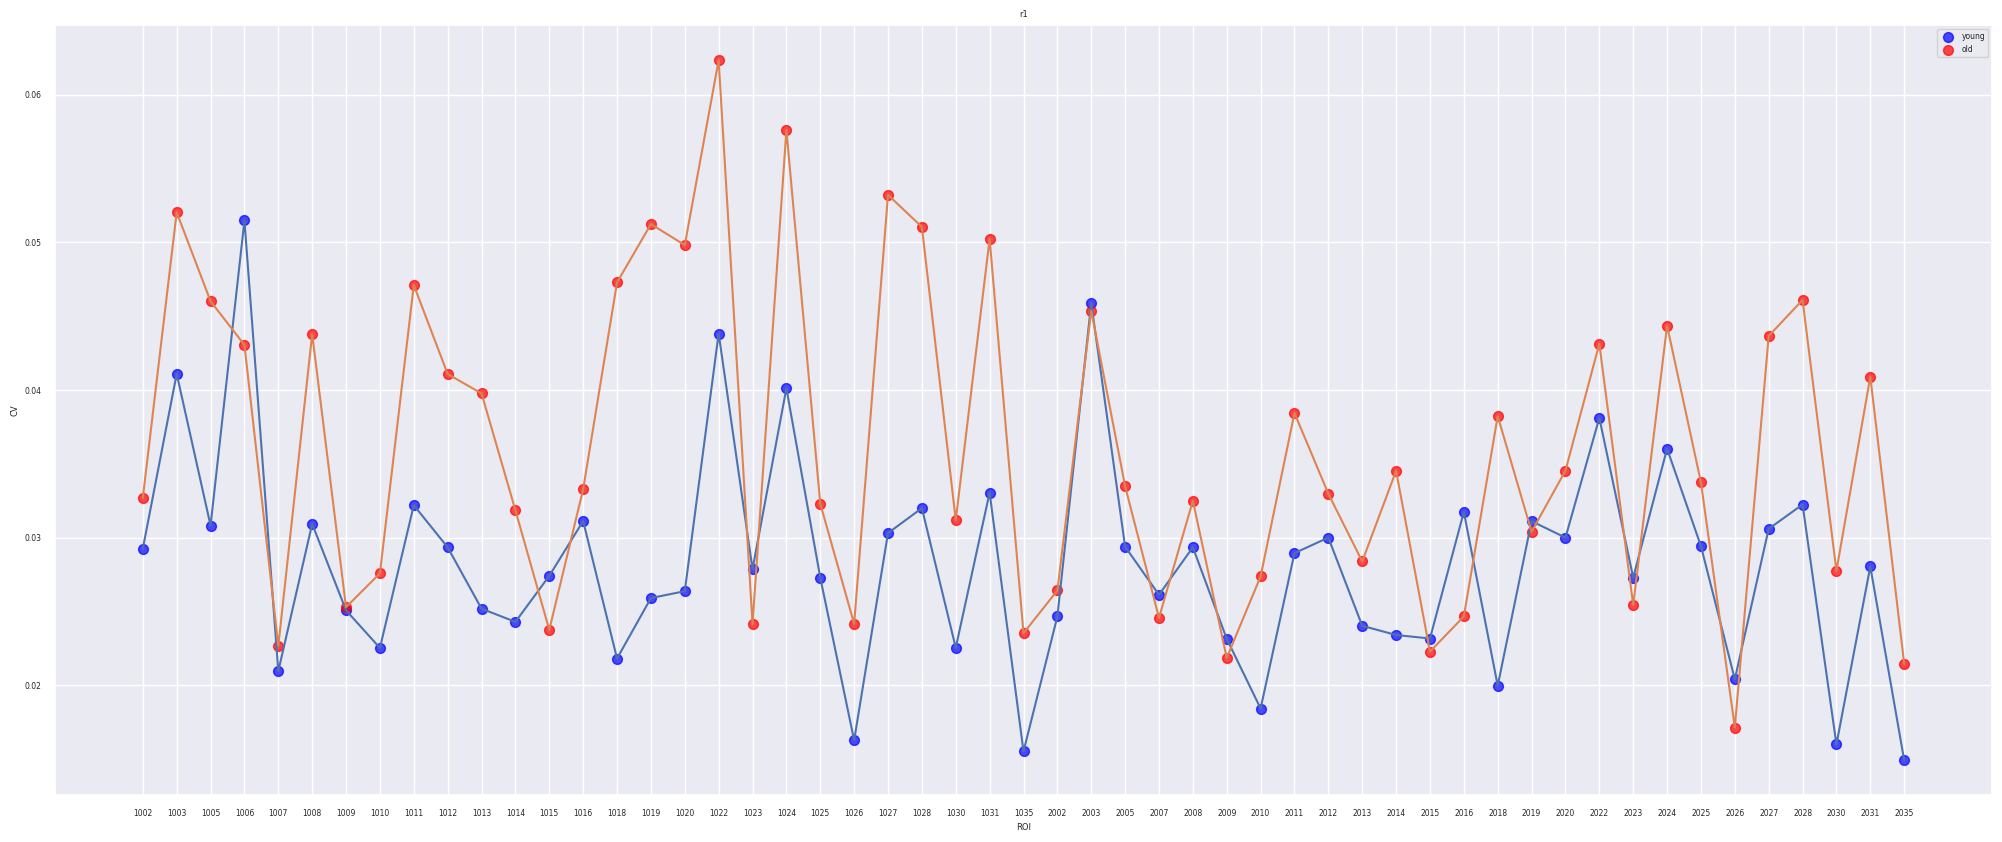

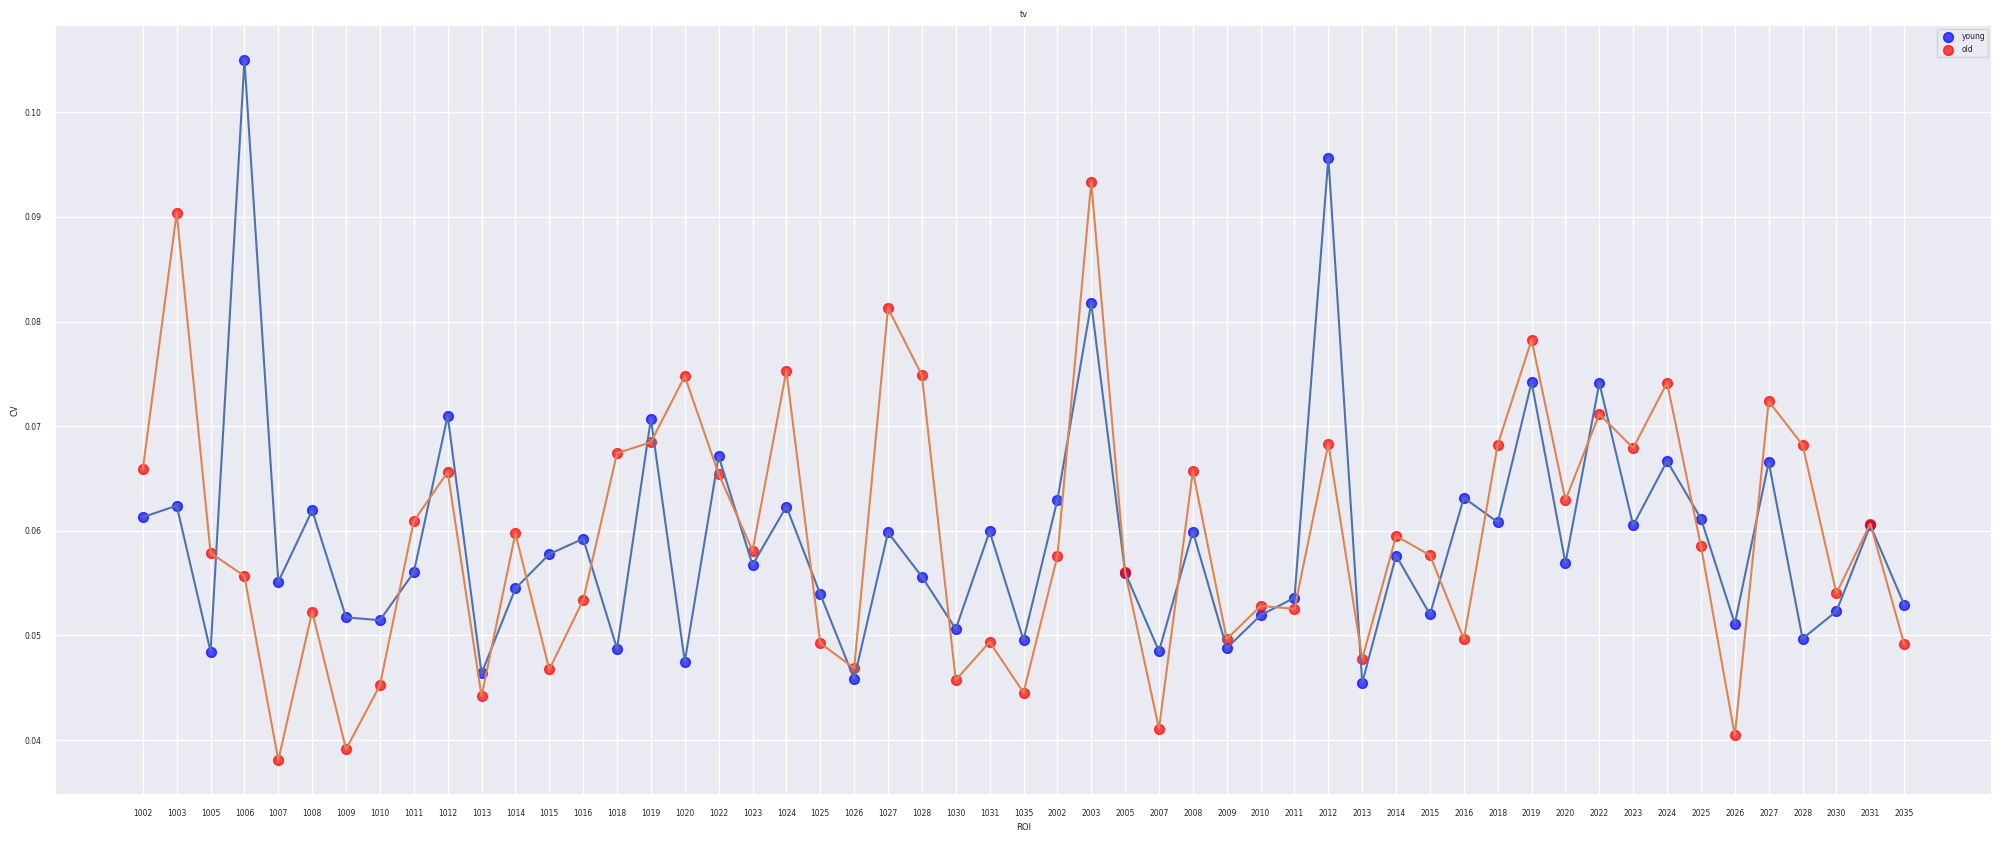

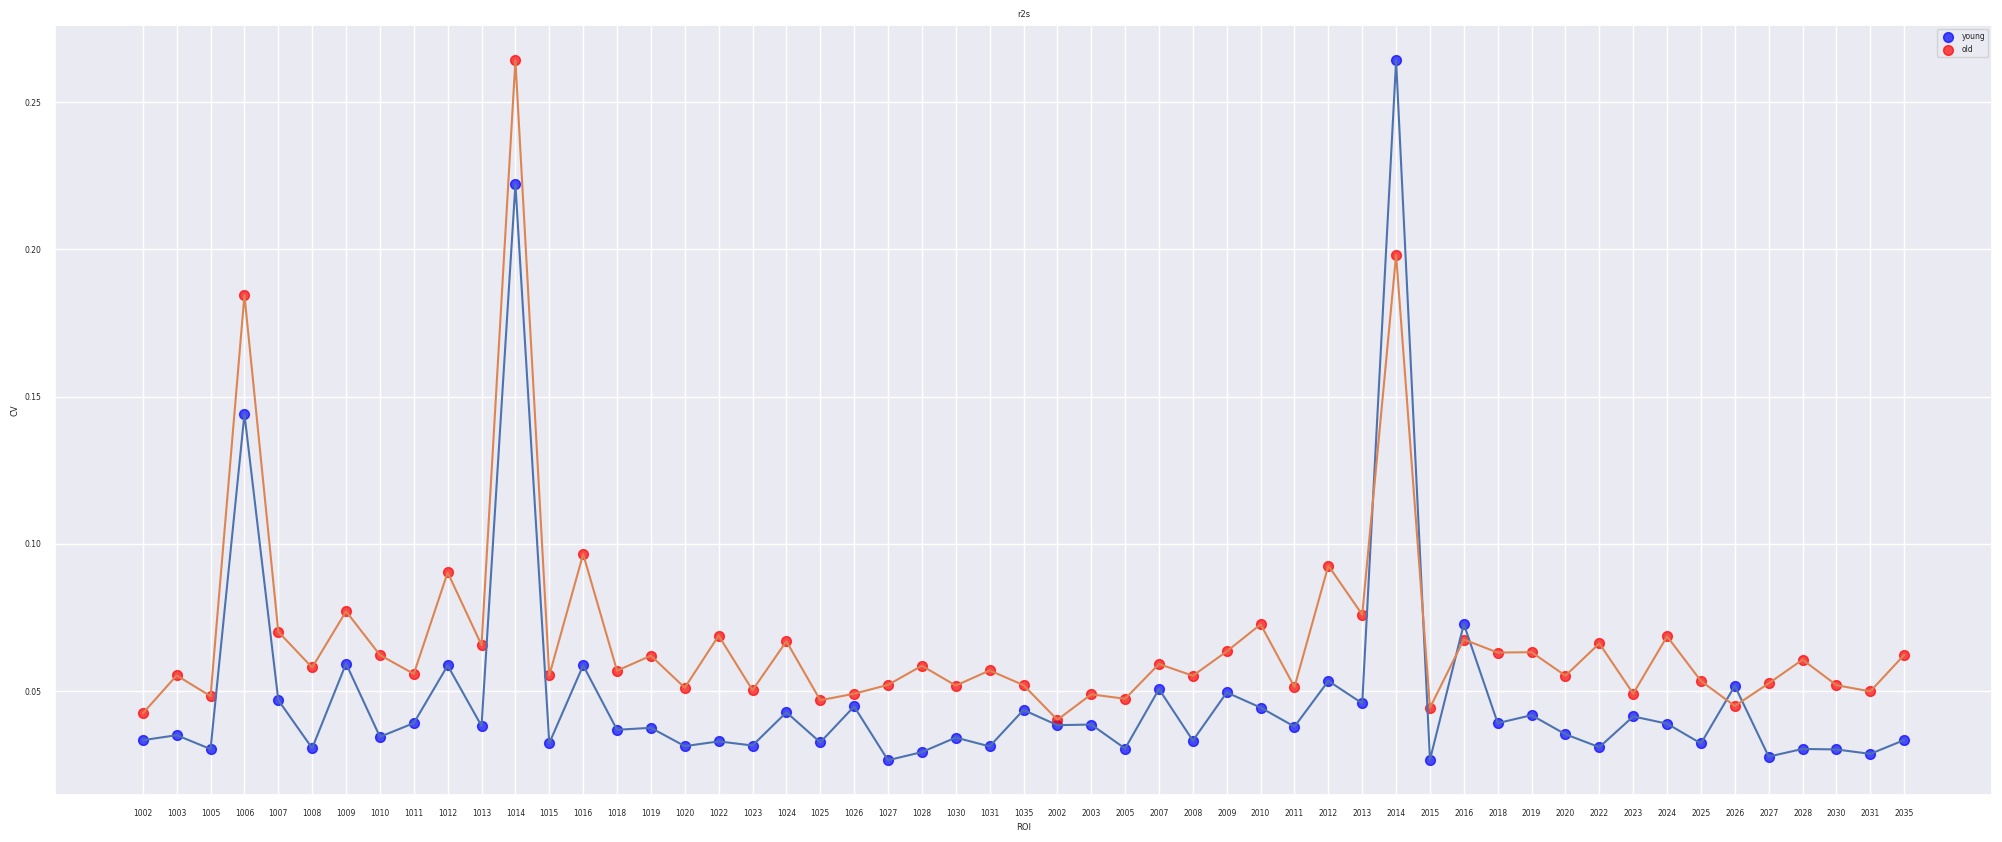

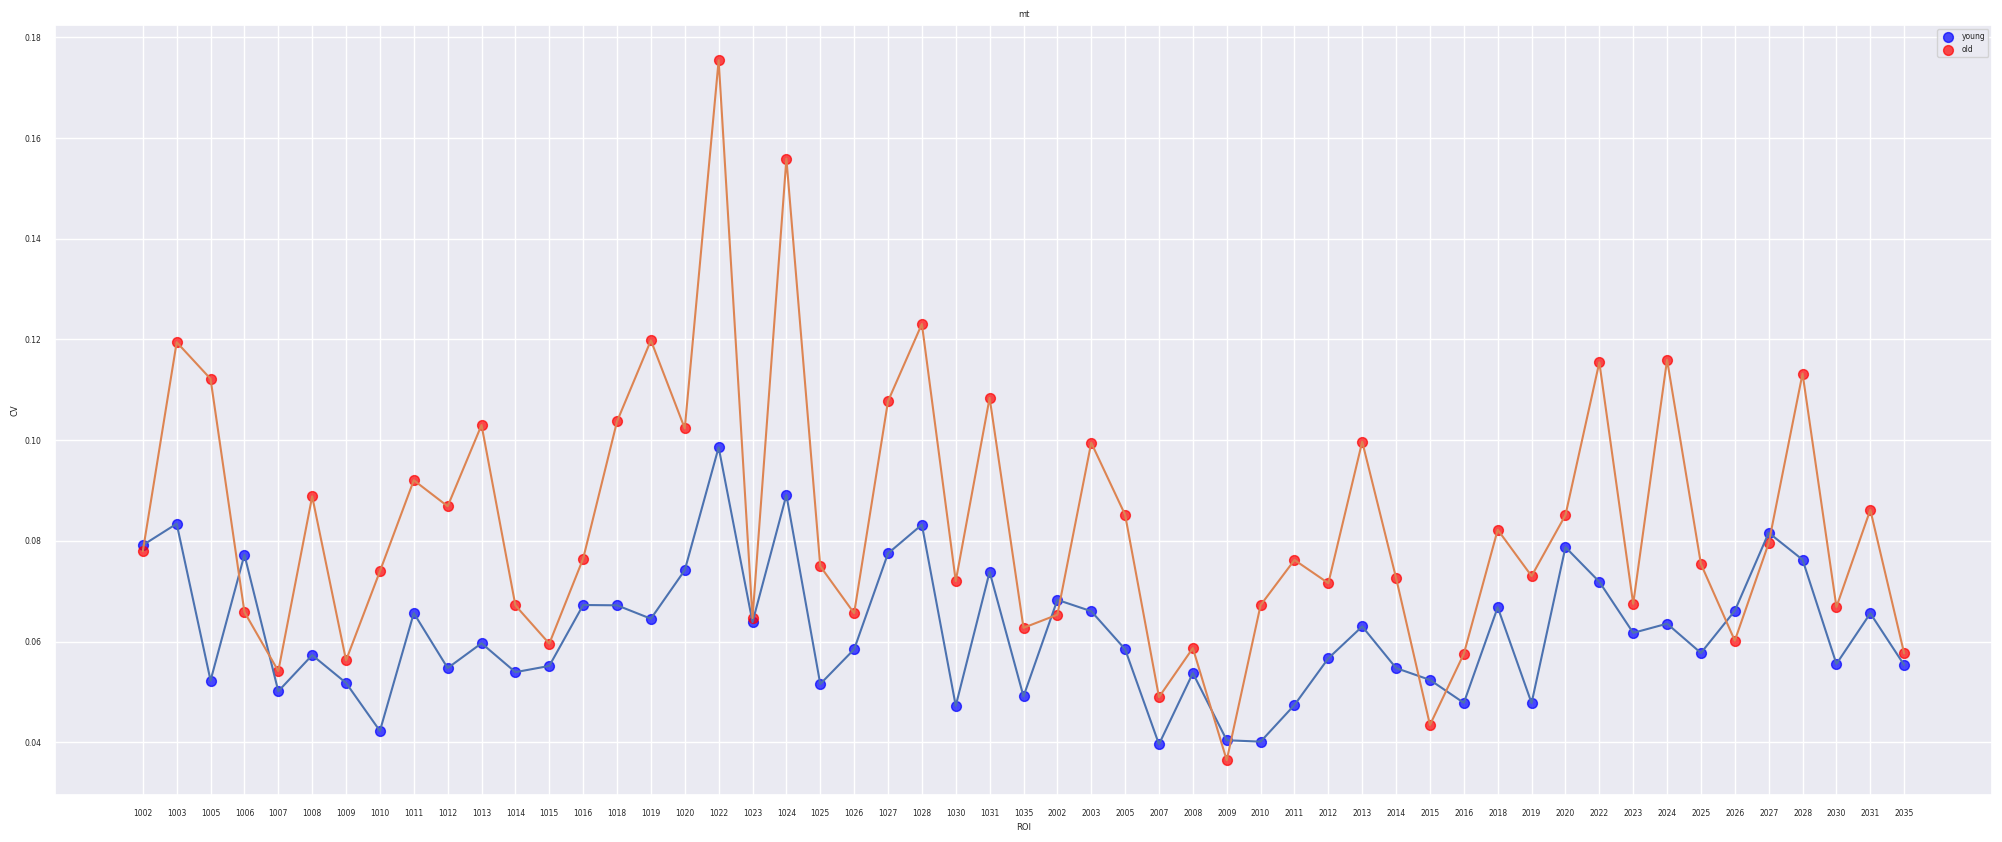

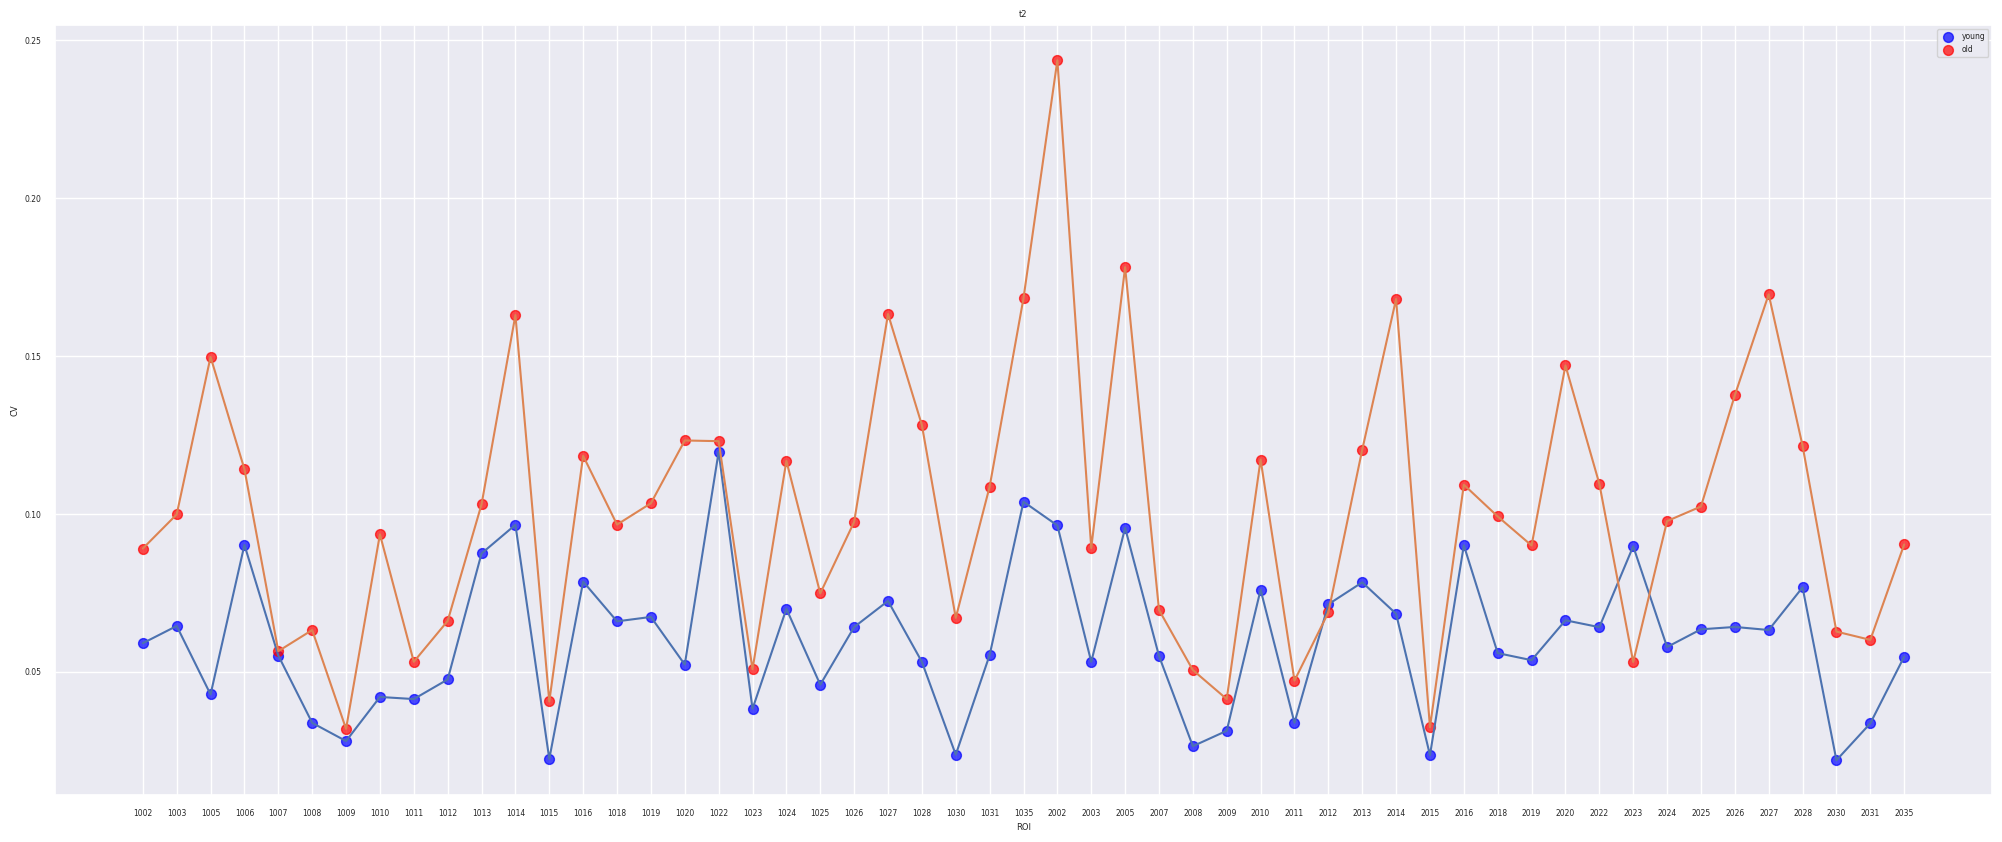

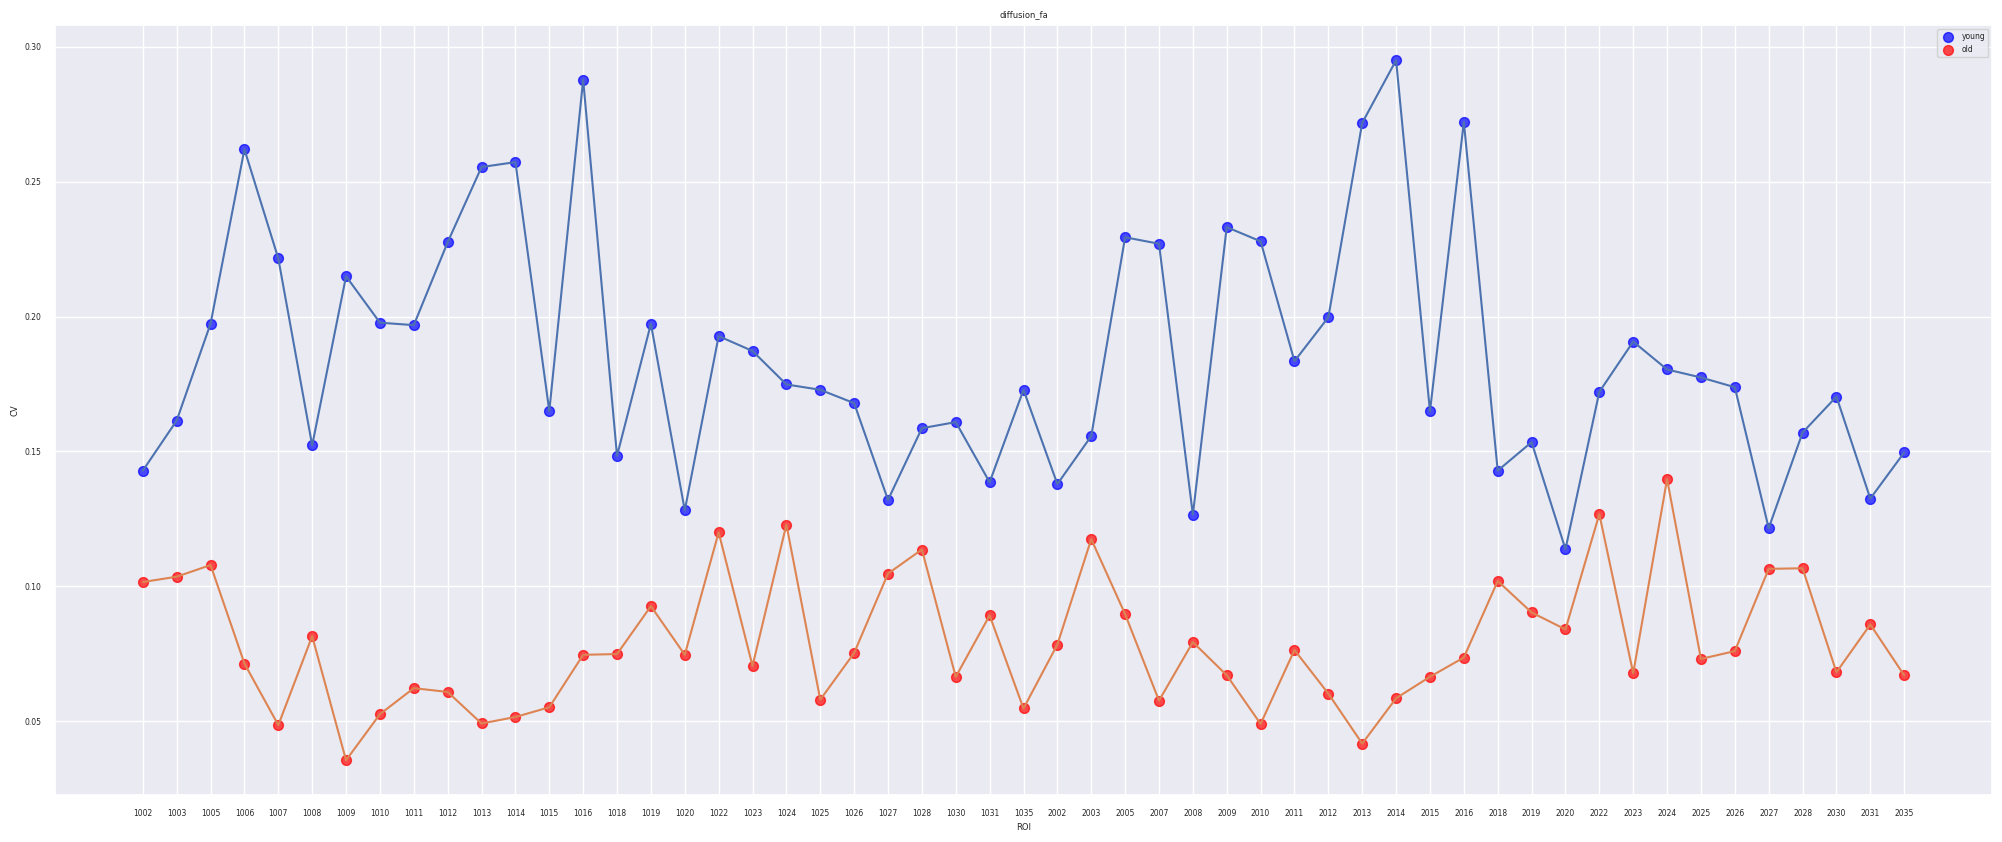

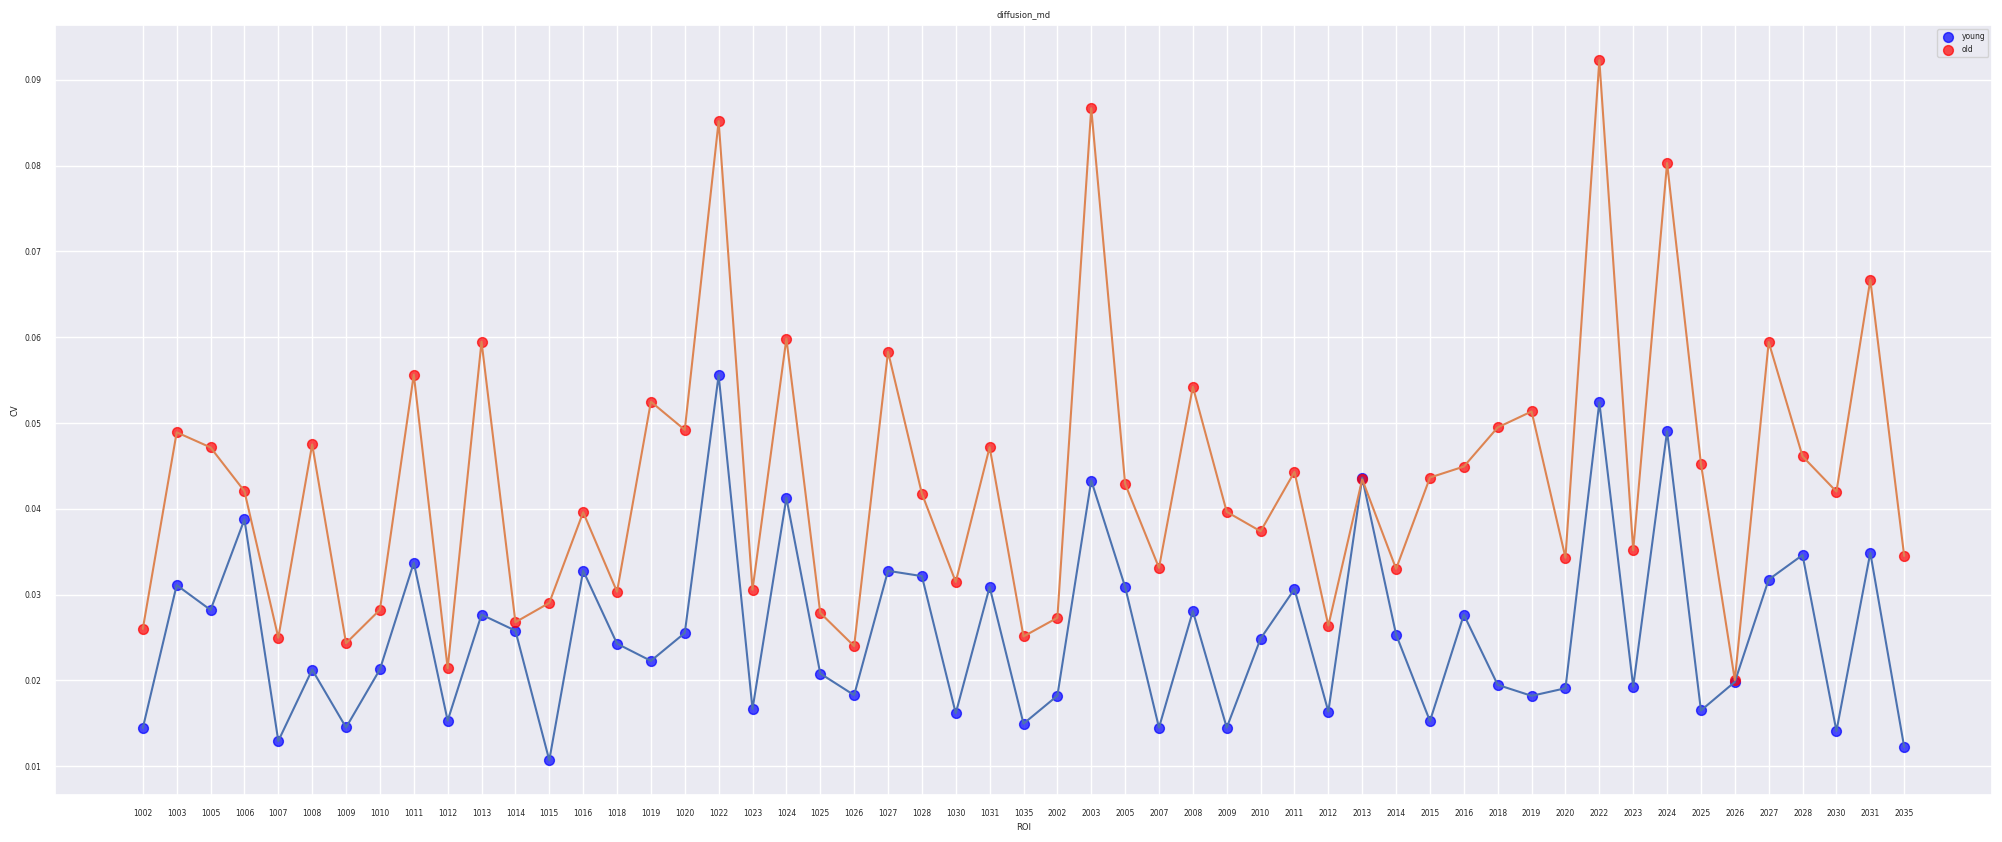

In [114]:
group_by_param = 'ROI'
x_axis = 'ROI'
data_groups = [(young_subjects, 'blue', 'young'), (old_subjects, 'red', 'old')]
calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=False, fig_size=(25, 10), connect_scatter=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


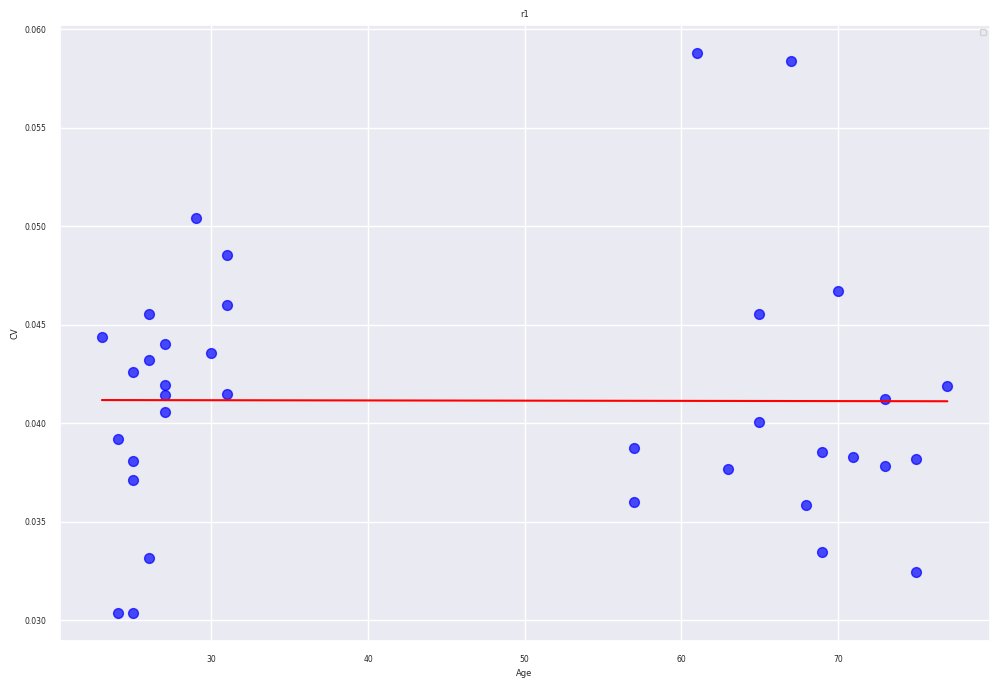

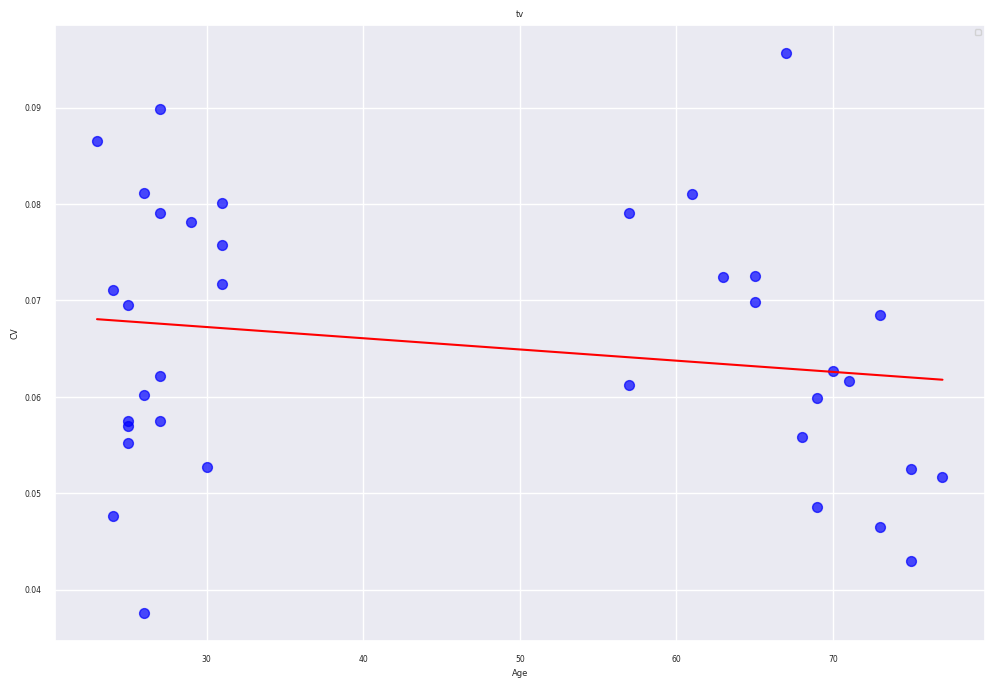

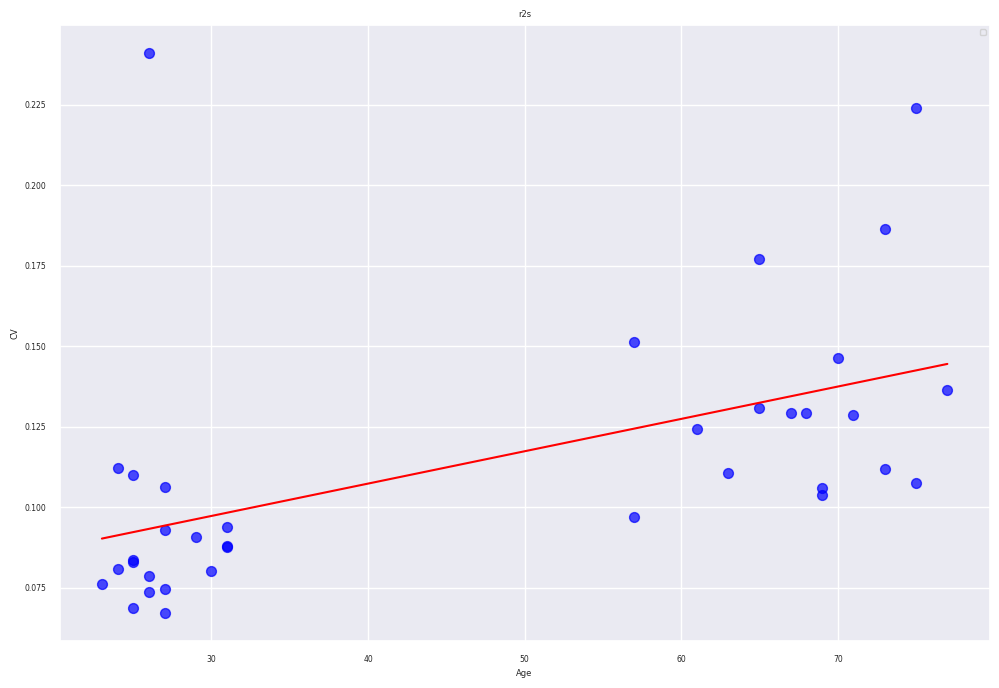

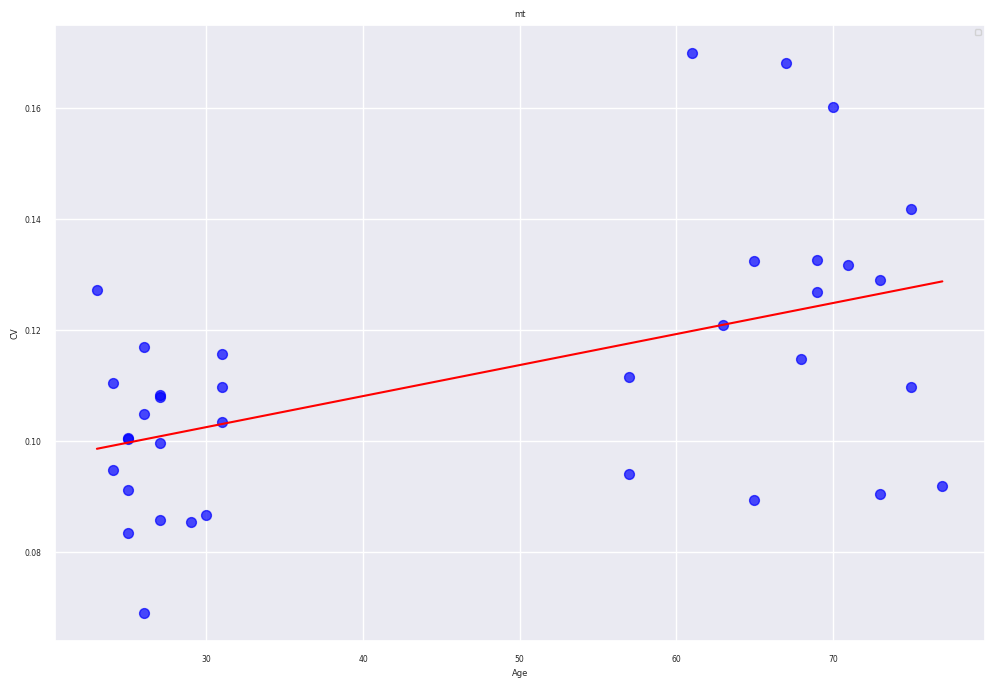

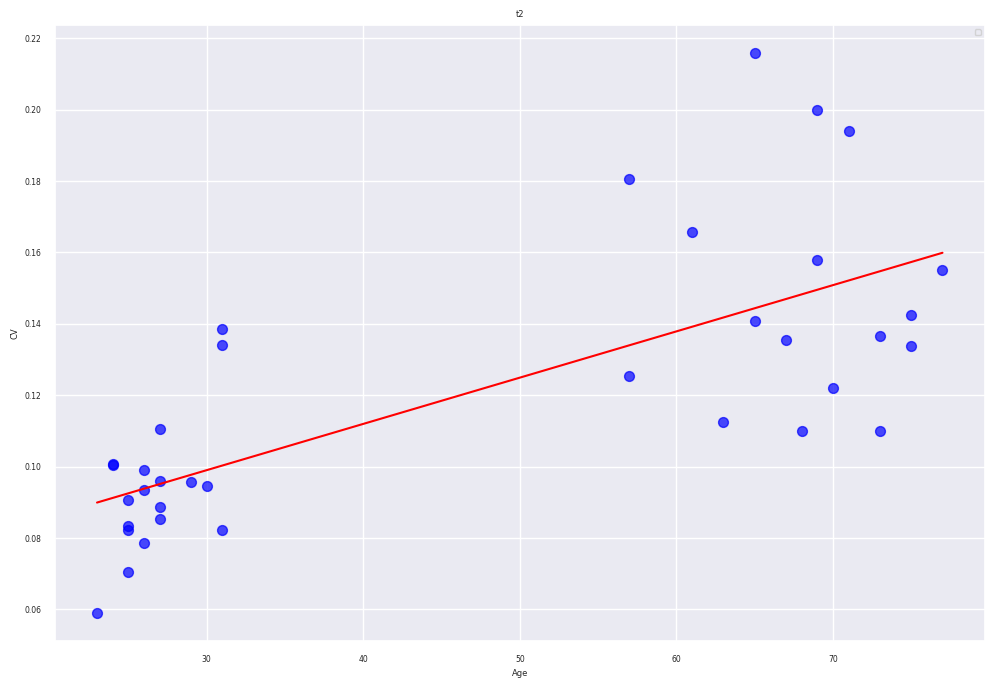

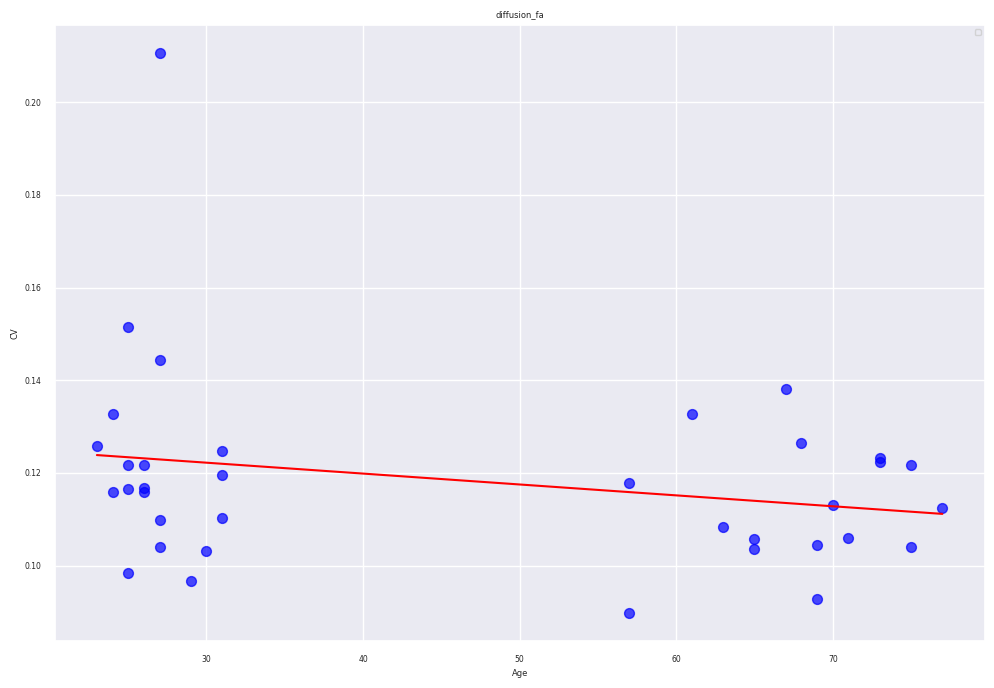

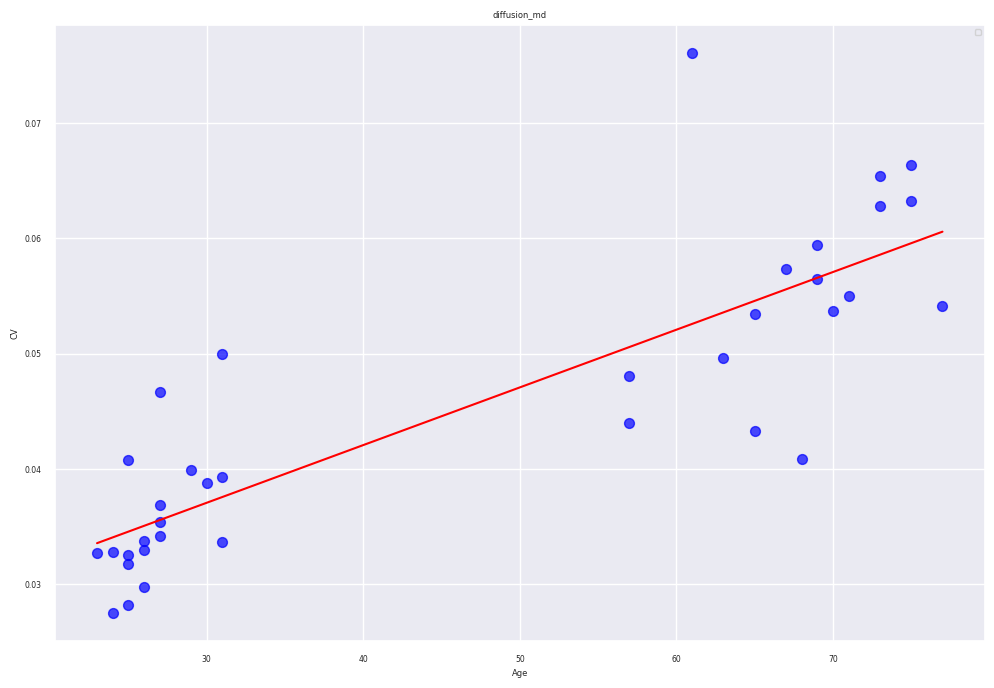

In [115]:
group_by_param = 'subjects'
x_axis = 'Age'
data_groups = [(chosen_data, 'blue', '')]
calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=True, fig_size=(12, 8))

In [ ]:
# Get the test subject
test_subject = subjects_raw_data.subjects.unique()[0]
x_axis = []
y_axis = []

# Filter the data for the test subject
test_subject_df = subjects_raw_data[subjects_raw_data['subjects'] == test_subject]
    
# Iterate over ROIs and print the lengths of the arrays
for roi in test_subject_df.ROI.unique():
    values = test_subject_df[test_subject_df.ROI == roi].iloc[0]['r1']
    x_axis.append(f'{roi}')
    y_axis.append(len(values))

plt.figure(figsize=(30, 20))  # Adjust figure size as needed
plt.scatter(x_axis, y_axis, color='red', s=50, alpha=0.7)
plt.xlabel('ROI')
plt.ylabel('num voxels')
plt.title(f'{param}')
plt.grid(True)

In [19]:
from scipy.spatial.distance import pdist, squareform

def create_affinity_matrix(data, params, group_name, metric='euclidean'):
    subjects = data.groupby('subjects')
    relevant_rois = list(data.ROI_name.unique())
    distances = np.zeros((len(relevant_rois),
                            len(relevant_rois)))

    for subject_name, subject_df in subjects:
        df = subject_df[params]
        dist = pdist(df, metric=metric)
        distance_matrix = pd.DataFrame(squareform(dist), index=relevant_rois, columns=relevant_rois)
        distances += distance_matrix.to_numpy()

    distances /= data.subjects.nunique()

    PlotsManager.plot_heatmap(distances, f'{group_name} affinity matrix', None)

    return distances

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:532: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


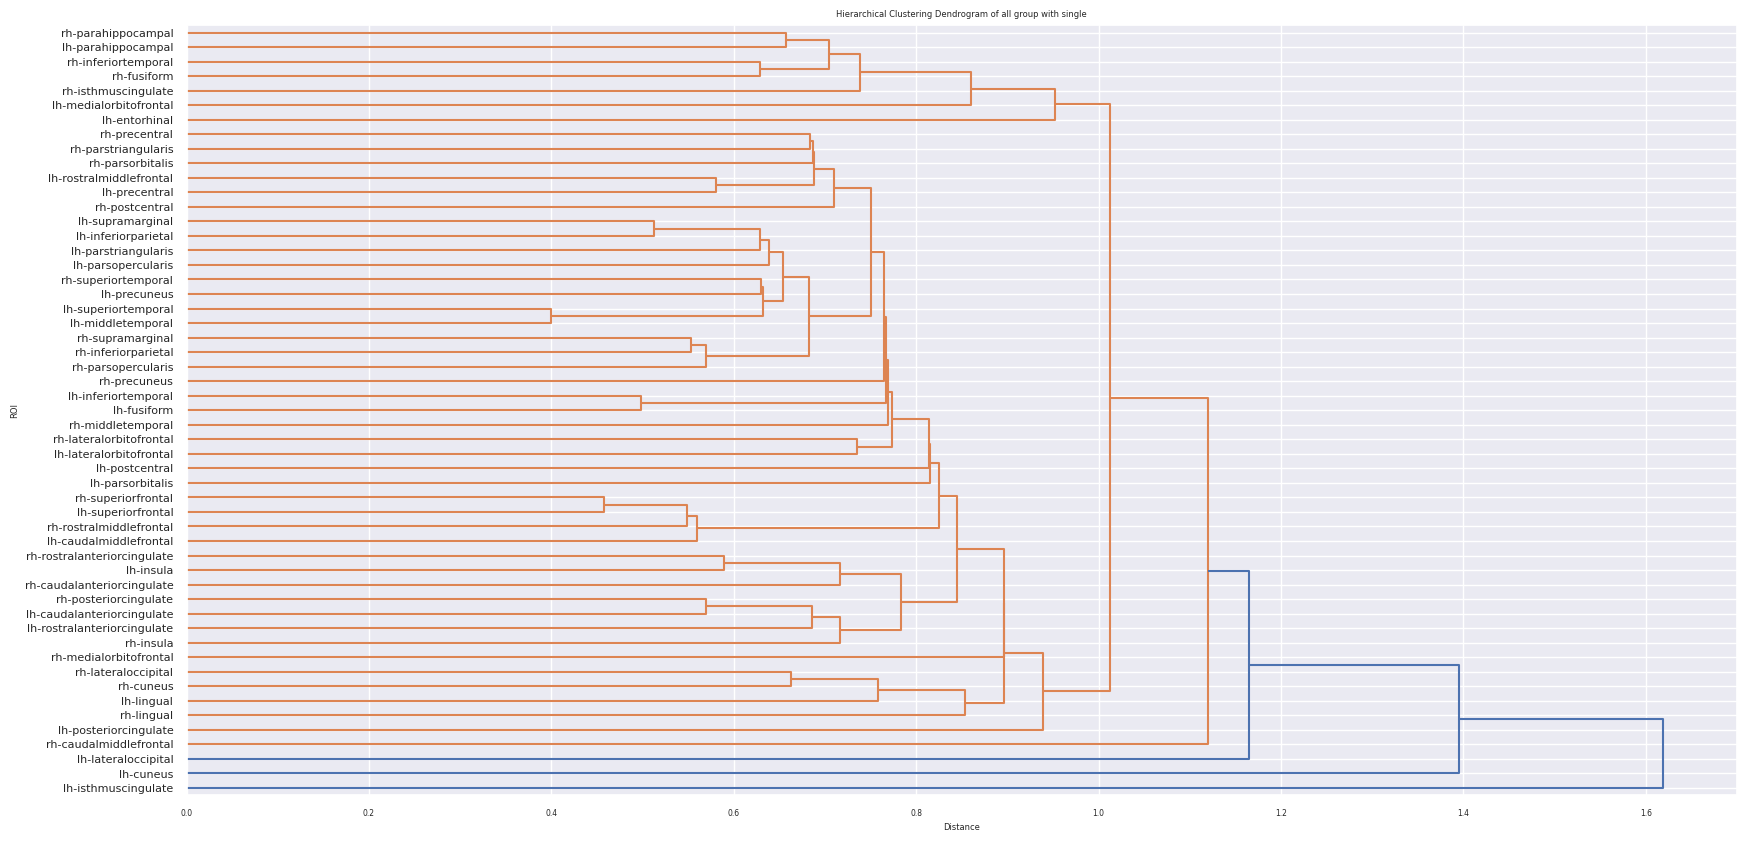

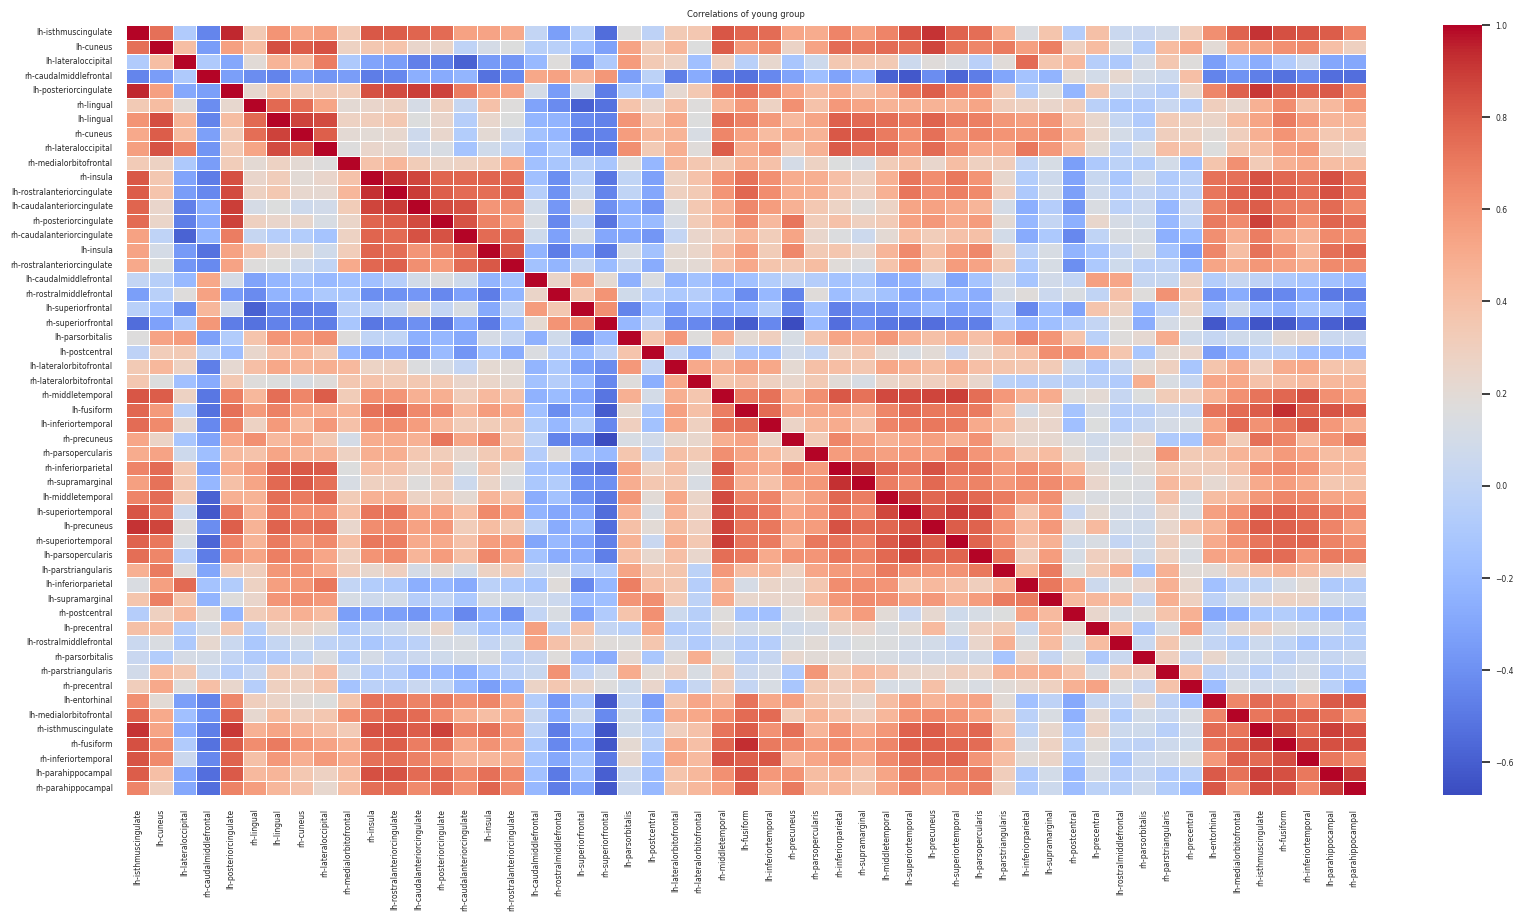

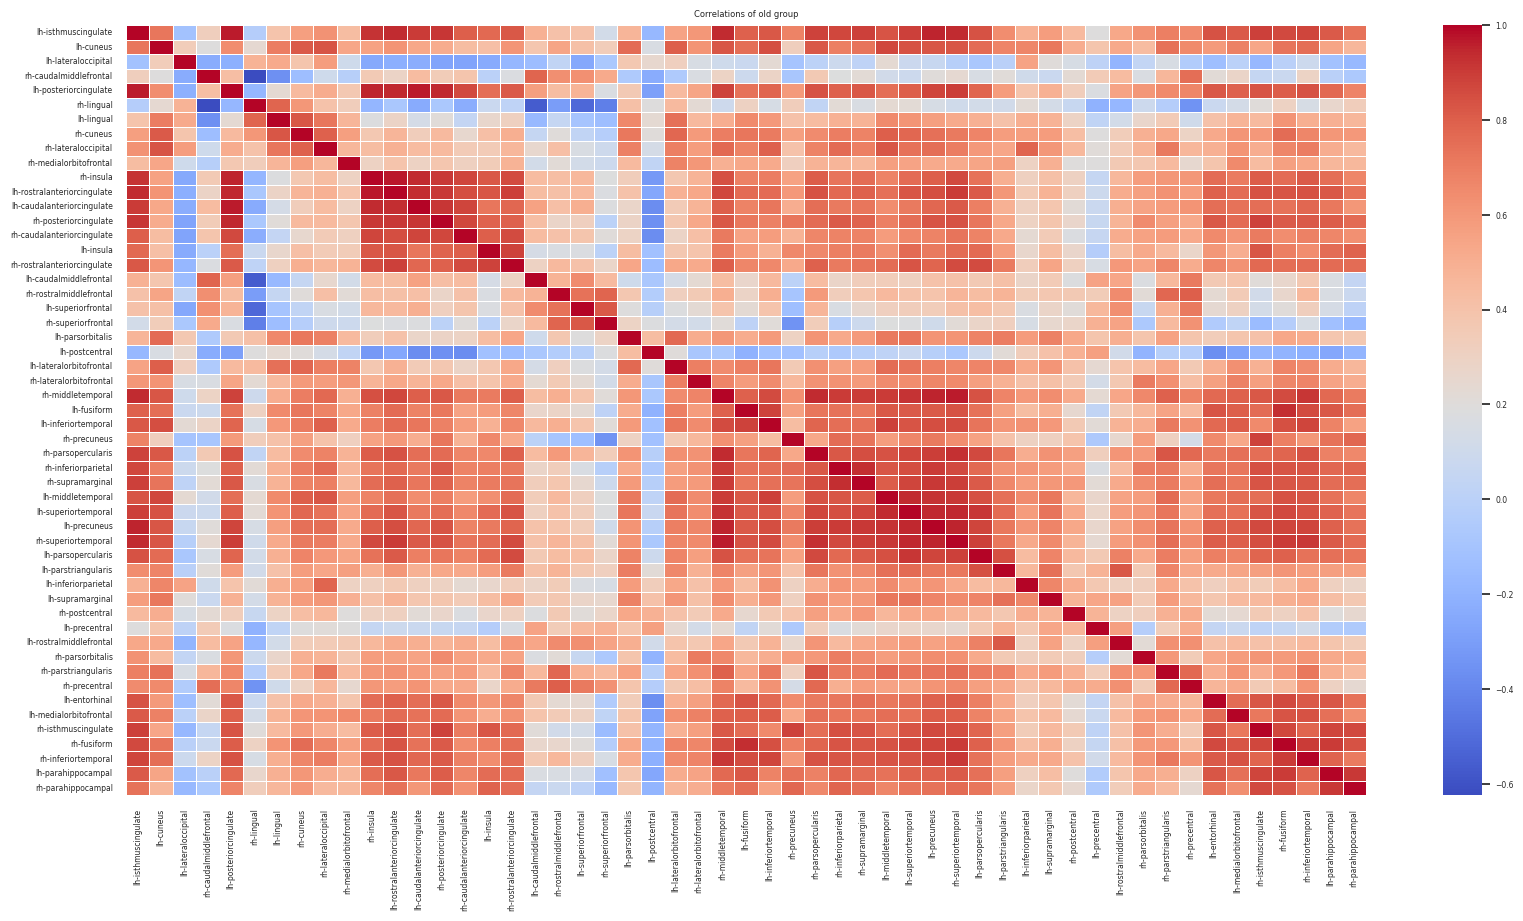

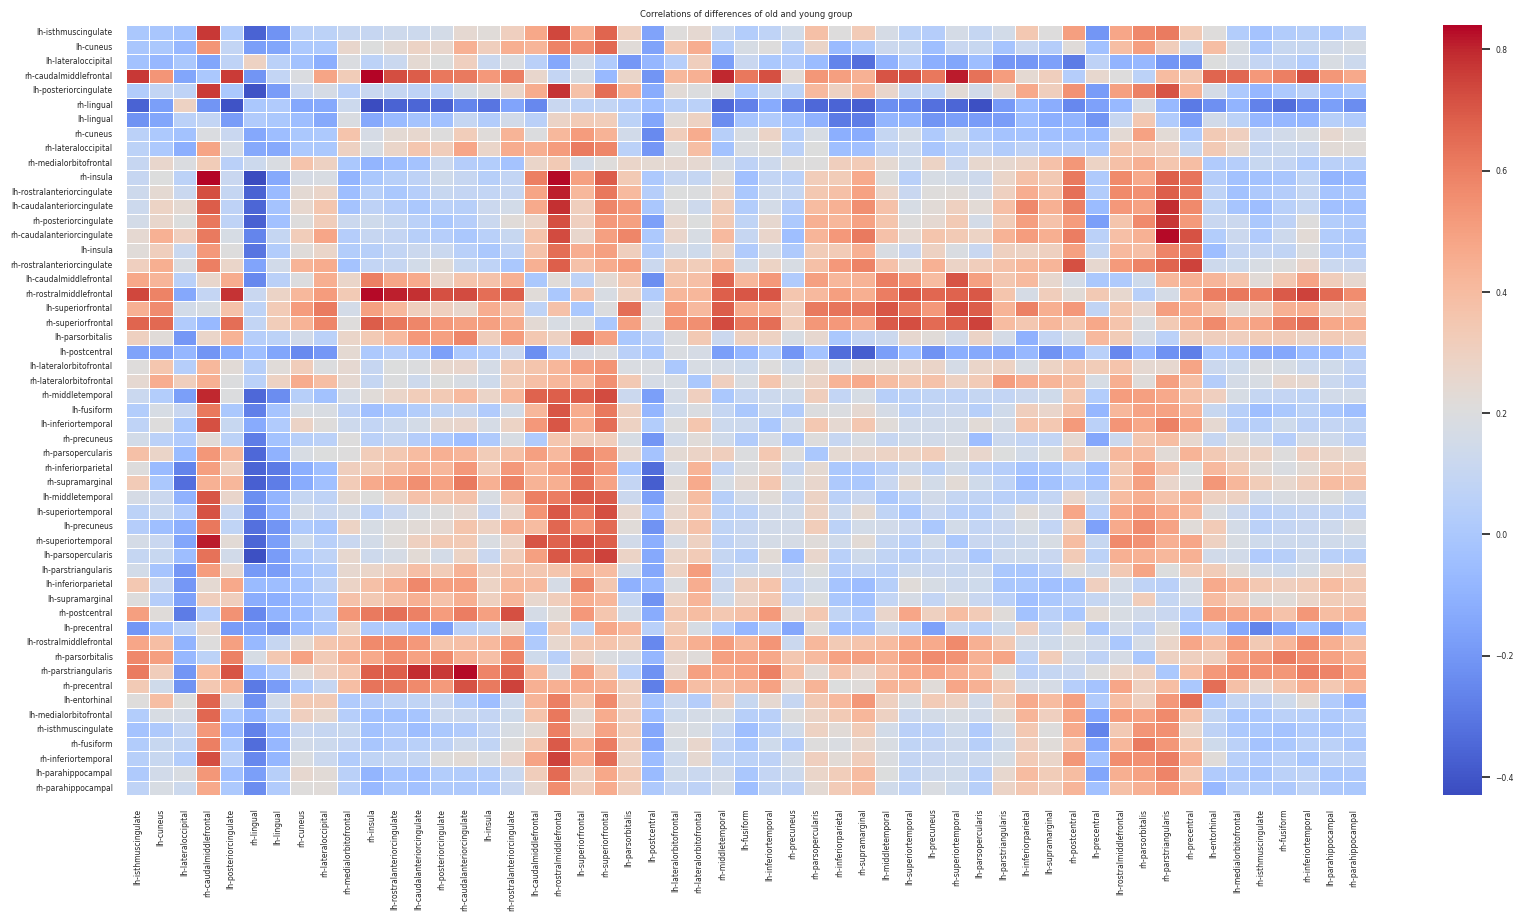

In [147]:
clusters_rois = StatisticsWrapper.hierarchical_clustering(chosen_data, params_to_work_with, 'single',
                                                            title="all")['dendrogram_data']['ivl']
young_result = StatisticsWrapper.roi_correlations(young_subjects, params_to_work_with, clusters_rois,
                                                    'young', method='pearson')
old_result = StatisticsWrapper.roi_correlations(old_subjects, params_to_work_with, clusters_rois, 'old', method='pearson')

PlotsManager.plot_heatmap(old_result - young_result, 'differences of old and young', project_name=None)

In [148]:
young_result['corr_mean'] = young_result.apply(np.mean, axis=1) - 1/young_result.shape[0]
old_result['corr_mean'] = old_result.apply(np.mean, axis=1) - 1/old_result.shape[0]

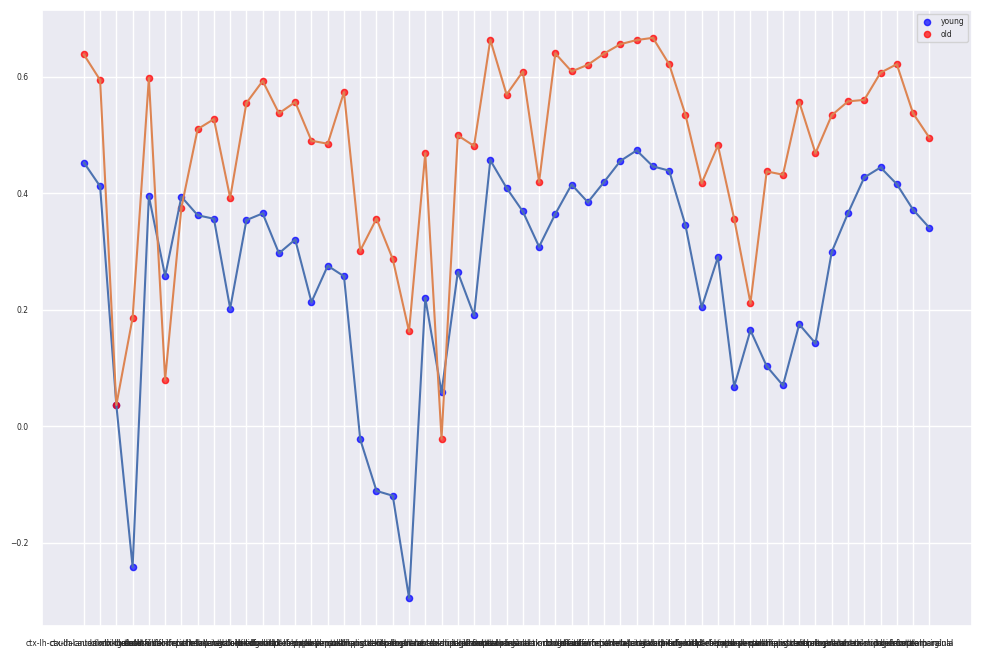

In [149]:
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
plt.scatter(chosen_rois_dict.values(), young_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='young')
plt.scatter(chosen_rois_dict.values(), old_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='old')
plt.plot(chosen_rois_dict.values(), young_result['corr_mean'].to_numpy())
plt.plot(chosen_rois_dict.values(), old_result['corr_mean'].to_numpy())
plt.legend()

In [ ]:
young_affinties = create_affinity_matrix(young_subjects, params_to_work_with, 'young', 'cosine')
old_affinties = create_affinity_matrix(old_subjects, params_to_work_with, 'old', 'cosine')
PlotsManager.plot_heatmap(old_affinties - young_affinties, 'dif', None)

In [63]:
import scipy.stats as stats

def t_test_per_parameter_per_area(data1, data2, rois, compare_column, params):
    """
    Calculates T-Test for each parameter per area between data1 and data2 and print them
    :param data1: df to compare with data2
    :param data2: df to compare with data1
    :param wanted_dict: only wanted
    :param compare_column: the column to get the data from and compare it
    :param data1_name:
    :param data2_name:
    :return: None
    """
    for param in params:
        num_of_significance = 0
        for area in rois.keys():
            results = stats.ttest_ind(a=data1[param][data1[compare_column] == area].to_numpy(),
                                        b=data2[param][data2[compare_column] == area].to_numpy())
            significance = results.pvalue <= 0.05
            # print(f"T_Test for {param} {rois[area]} significance:{significance}, results: {results}")

            if significance:
                num_of_significance += 1
        print(f'param {param} number of areas with significance differences: {num_of_significance}')   

In [74]:
t_test_per_parameter_per_area(young_subjects, old_subjects, chosen_rois_dict, 'ROI', params_to_work_with)

param r1 number of areas with significance differences: 39
param tv number of areas with significance differences: 21
param r2s number of areas with significance differences: 21
param mt number of areas with significance differences: 27
param t2 number of areas with significance differences: 31
param diffusion_fa number of areas with significance differences: 22
param diffusion_md number of areas with significance differences: 27
param Slope-tv-r1 number of areas with significance differences: 10
param Slope-tv-r2s number of areas with significance differences: 10
param Slope-tv-mt number of areas with significance differences: 17
param Slope-tv-t2 number of areas with significance differences: 1
param Slope-tv-diffusion_fa number of areas with significance differences: 2
param Slope-tv-diffusion_md number of areas with significance differences: 2
param Slope-r2s-r1 number of areas with significance differences: 8
